In [199]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from numpy.random import dirichlet as diri

dl = DataLib("SignalData")

# Intro

What indicators should we choose? Why?
- FX Appreciation
- Monetary Base (captures something orthogonal to movements in FX) 
- GDP (are there any other data that we can supplement this with?)

Which shouldn't we choose? Why? 
- Change in GDP: as the prospectus outlines, changes in GDP are revised regularly. Additionally, GDP statistics are released with a lag, so wouldn't be practical for a real investment system. 
- Relative Stock/Bond Performance: this indicator seems to have an unsatisfying and hand-wavy explanation for how it affects bond returns. 
- Monetary Base: since monetary base in only useful if we assume an increase in monetary base is indicative of expansionary policy. This is not the case right now amidst the COVID-19 pandemic, however. (Is this a good enough reason to discount it?)

How are the indicators we have chosen related? Or are they unrelated? 
- The exchange rate is a function of inflow/outflow of money, which is related to economic growth, interest rates, and monetary base. So yes, all three are related. 

it may be interesting to consider not only each indicator in isolation, but how they may or may not complement one another -- what potential synergies might they have? redundancies?

# GDP
TODO: 
1. provide an overview of why we are using this indicator
2. (decide what data could supplement GDP)
3. (decide what data feeds we are going to need)
4. (find these on eikon)
5. (how should we manipulate the data)
6. (get some dataframes from datalib and Eikon)
7. generate an indicator

**1 - overview**

Questions that are relevant here: why do we use GDP for bond price prediction? What even is GDP? How is it measured? Are there any problems with how it is measured? Do we want to look at absolute GDP, or change, and why? 
- GDP: Gross domestic product. The sum of transactions within an economy. A proxy for the busyness of an economy. 
- It is measured in dollars. Some GDP measures take a while to be released, and hence may be somewhat impractical for a real investment system. 
- Absolute GDP is pretty nonsensical when we're trying to predict soveign bonds. The US having 100x more GDP than New Zealand tells us nothing about the price movements of bonds in those respective countries. Change is a more useful measure than magnitude for this reason. 

**2 - what other data could supplement GDP?**
- GDP itself
- unemployment
- HDI

**7 - generating an indicator**

Questions to be addressed:
- How should we apply smoothing? 

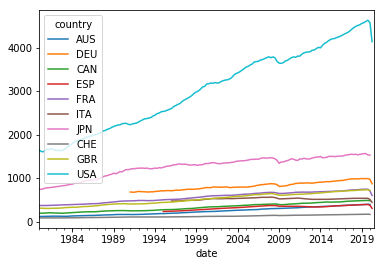

In [47]:
# Reindex GDP to monthly rather than quarterly for smoothing purposes.
rGDP = dl.pull('GDP/real')
rGDP.plot()

Let's look at the change in GDP - that might be more informative. Plotting the USA GDP change we notice fairly slow growth over the past 40 years, and a major negative dip since COVID-19. 

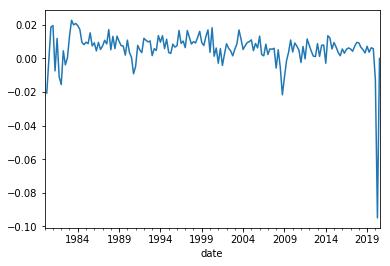

In [49]:
rGDP_change = rGDP.pct_change()
rGDP_change['USA'].plot()

Let's try smoothing that curve a little. We'll start with a yearly rolling average.

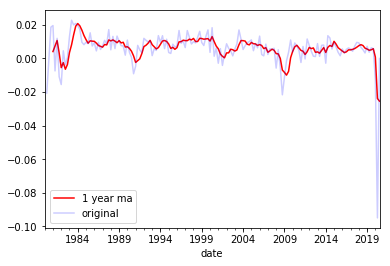

In [68]:
rGDP_1ma = rGDP_change.rolling(4).mean()
rGDP_1ma['USA'].plot(color='red')
rGDP_change['USA'].plot(color='blue', alpha=0.2)
plt.legend(['1 year ma', 'original'])

# Sample Returns Stream
To speed up development, here we're going to make a two dummy signals. Our signal will be a time series of data telling us how long and how short to go in each bond market. Our long and short positions must be offsetting. We will use two dummy signals: 
- An equal weighting scheme (all long)
- A randomly weighted scheme using a Dirichlet distribution (equal long/short)

In [210]:
# Let's just use the year 2000. 
BondReturnIndex = dl.pull("BondRetIdx/LocalFX")
index = BondReturnIndex.index
mask = (index >= '2000-1-1') & (index < '2001-1-1')
df = BondReturnIndex.loc[mask]

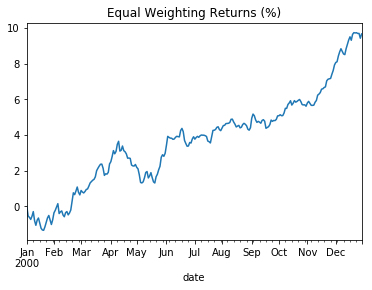

In [206]:
abbr_return_index = BondReturnIndex[mask]
abbr_returns = abbr_return_index.pct_change()
equal_weight_returns = (0.1 * abbr_returns).sum(axis=1)
cumul_returns = ((equal_weight_returns + 1).cumprod() - 1) * 100
cumul_returns.plot(title='Equal Weighting Returns (%)')

Let's now generate the random signal with equal weight in longs and shorts. 

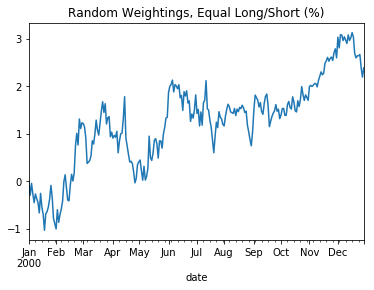

In [213]:
# Create a random signal with longs and shorts. 
signal = pd.DataFrame(df)
for ind in df.index: 
    signal.at[ind] = np.append(diri(np.ones(5),size=1), -1*diri(np.ones(5),size=1))

# Calculate the returns. 
custom_weight_returns = (signal * abbr_returns).sum(axis=1)
cumul_returns = ((custom_weight_returns + 1).cumprod() - 1) * 100
cumul_returns.plot(title="Random Weightings, Equal Long/Short (%)")